<a href="https://colab.research.google.com/github/MuhammadNurilHuda/MachineLearningProject/blob/main/Diabetic_Foot_Thermogram_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O Dataset2.zip https://github.com/MuhammadNurilHuda/MachineLearningProject/blob/main/Dataset/Dataset2.zip?raw=true

--2021-12-20 05:41:39--  https://github.com/MuhammadNurilHuda/MachineLearningProject/blob/main/Dataset/Dataset2.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/MuhammadNurilHuda/MachineLearningProject/raw/main/Dataset/Dataset2.zip [following]
--2021-12-20 05:41:39--  https://github.com/MuhammadNurilHuda/MachineLearningProject/raw/main/Dataset/Dataset2.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MuhammadNurilHuda/MachineLearningProject/main/Dataset/Dataset2.zip [following]
--2021-12-20 05:41:39--  https://raw.githubusercontent.com/MuhammadNurilHuda/MachineLearningProject/main/Dataset/Dataset2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting

In [32]:
!wget https://raw.githubusercontent.com/MuhammadNurilHuda/MachineLearningProject/main/Dataset/Metadata.csv

--2021-12-20 06:15:03--  https://raw.githubusercontent.com/MuhammadNurilHuda/MachineLearningProject/main/Dataset/Metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4350 (4.2K) [text/plain]
Saving to: ‘Metadata.csv’

Metadata.csv        100%[===================>]   4.25K  --.-KB/s    in 0s      

2021-12-20 06:15:04 (38.3 MB/s) - ‘Metadata.csv’ saved [4350/4350]



In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

np.random.seed(42)

In [4]:
import zipfile, os

local_zip = '/content/Dataset2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('Dataset2')
zip_ref.close()

In [5]:
path = '/content/Dataset2/Dataset'
images_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*', '*.png'))}

In [6]:
classes = {0:('P','Negatif'),
           1:('N','Positif')}

In [60]:
df = pd.read_csv('/content/Metadata.csv')

In [38]:
df.head()

,id,label
0,DM001_M_L,P
1,DM002_M_L,P
2,DM003_F_L,P
3,DM004_M_L,P
4,DM005_M_L,P


In [61]:
df['path'] = df['id'].map(images_path.get)
df['tes'] = df['label'].map(classes.get)
df['label_full'] = pd.Categorical(df['label']).codes

In [40]:
df.head()

,id,label,path,tes,label_full
0,DM001_M_L,P,/content/Dataset2/Dataset/Positif/DM001_M_L.png,None,1
1,DM002_M_L,P,/content/Dataset2/Dataset/Positif/DM002_M_L.png,None,1
2,DM003_F_L,P,/content/Dataset2/Dataset/Positif/DM003_F_L.png,None,1
3,DM004_M_L,P,/content/Dataset2/Dataset/Positif/DM004_M_L.png,None,1
4,DM005_M_L,P,/content/Dataset2/Dataset/Positif/DM005_M_L.png,None,1


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          334 non-null    object
 1   label       334 non-null    object
 2   path        334 non-null    object
 3   tes         0 non-null      object
 4   label_full  334 non-null    object
 5   image       334 non-null    object
dtypes: object(6)
memory usage: 15.8+ KB


In [63]:
df['label_full'] = df['label_full'].astype(object)

In [64]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((128,128))))

In [65]:
df['image'].map(lambda x: x.shape).value_counts()

(128, 128, 3)    334
Name: image, dtype: int64

In [120]:
X = df['image']
y = df['label_full']

<BarContainer object of 2 artists>

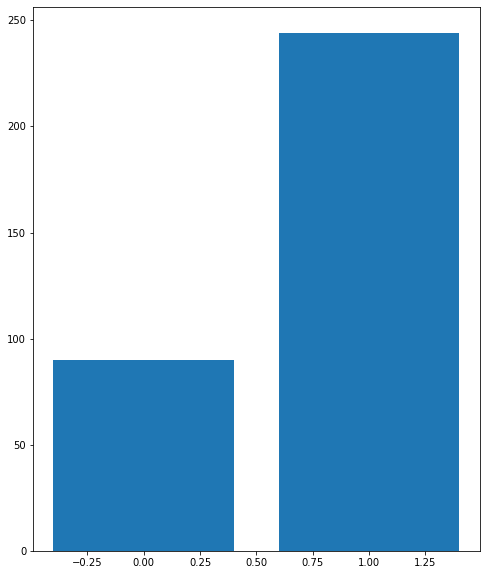

In [121]:
plt.figure(figsize=(8,10))
plt.bar(y.unique(), y.value_counts())

In [122]:
X = X.values
X = X/255
X.shape

(334,)

In [123]:
ls = []
for _ in X:
    ls.append(_)
X = np.array(ls)
print(X.shape)

(334, 128, 128, 3)


In [124]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=42)
x_train, x_val, y_train, y_val =   train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [125]:
y_train = to_categorical(y_train, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)

In [137]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./225,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [138]:
datagen.fit(x_train)
val_datagen.fit(x_val)

In [139]:
from keras.applications.resnet import ResNet50
resnet = ResNet50(include_top=False, input_shape=(128,128,3),pooling = 'avg', weights = 'imagenet');

for layer in resnet.layers:
    layer.trainable = True

In [140]:
model_resnet = resnet.output
model_resnet = Flatten()(model_resnet)

model_resnet = Dense(128, activation='relu')(model_resnet)
model_resnet = Dropout(0.2)(model_resnet)
model_resnet = Dense(64,activation='relu')(model_resnet)
output = Dense(2, activation='sigmoid')(model_resnet)

model_resnet = Model(inputs=resnet.input, outputs=output)

model_resnet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [141]:
model_resnet.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [142]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto', restore_best_weights=True)

In [152]:
history = model_resnet.fit(
    x_train, y_train,
    epochs=100,
    # callbacks=[early_stop],
    validation_data=(x_val, y_val),
    verbose=1
    )

Epoch 1/100
7/7 [==============================] - 62s 9s/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.6673 - val_accuracy: 0.7778
Epoch 2/100
7/7 [==============================] - 60s 9s/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.6750 - val_accuracy: 0.7778
Epoch 3/100
7/7 [==============================] - 60s 9s/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.7060 - val_accuracy: 0.7778
Epoch 4/100
7/7 [==============================] - 61s 9s/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.7379 - val_accuracy: 0.2963
Epoch 5/100
7/7 [==============================] - 60s 9s/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.8153 - val_accuracy: 0.2222
Epoch 6/100
7/7 [==============================] - 60s 9s/step - loss: 0.0131 - accuracy: 0.9953 - val_loss: 1.3888 - val_accuracy: 0.2222
Epoch 7/100
7/7 [==============================] - 60s 9s/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 2.3882 - val_accuracy: 0.2222
Epoch 8/100
7/7 [==========

In [153]:
model_resnet.save('/content/drive/MyDrive/Praktikum_Machine_Learning/model_resnet_diabet.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [154]:
score = model_resnet.evaluate(x_train, y_train)

7/7 [==============================] - 12s 2s/step - loss: 1.2729 - accuracy: 0.7465


In [155]:
score = model_resnet.evaluate(x_val, y_val)

2/2 [==============================] - 3s 1s/step - loss: 0.8404 - accuracy: 0.7963


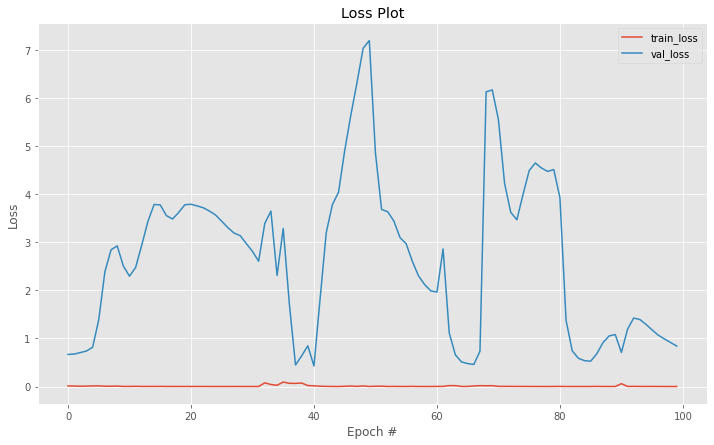

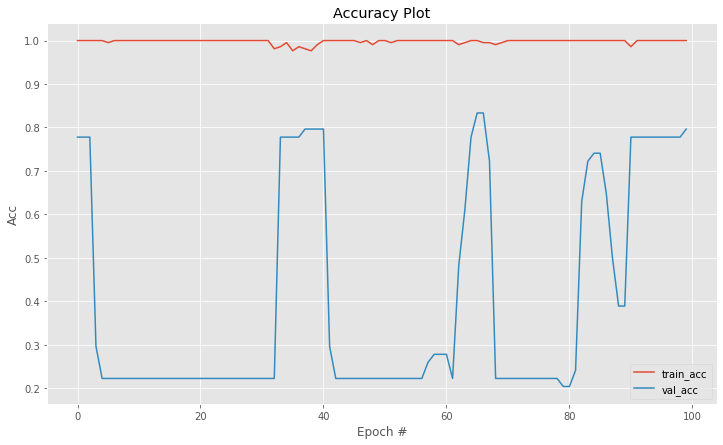

In [156]:
plt.style.use("ggplot")
plt.figure(figsize=(12,7))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.style.use("ggplot")
plt.figure(figsize=(12,7))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [157]:
y_pred  = model_resnet.predict(x_val).round()

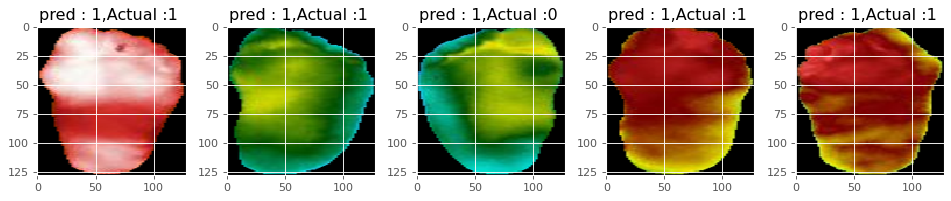

In [158]:
from matplotlib.pyplot import figure
correct = np.nonzero(y_pred == y_val)[0]
figure(figsize=(12, 7), dpi=80)

k = 0 
for c in correct[:10]:
            plt.subplot(2,5,k+1)
            plt.imshow(x_val[k].reshape(128,128,3) , interpolation='none')
            plt.title(f"pred : {y_pred[k].argmax(axis = 0)},Actual :{y_val[k].argmax(axis = 0)} ")
            plt.tight_layout()
            k += 1

In [159]:
from keras.models import load_model

model_resnet = load_model('/content/drive/MyDrive/Praktikum_Machine_Learning/model_resnet_diabet.h5')

In [160]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_resnet)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/Praktikum_Machine_Learning/model_resnet_diabet.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9pvtnlx0/assets


In [150]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy='auto',random_state=42)
# X_res, y_res = sm.fit_resample(X, y)

In [151]:
# from imblearn.over_sampling import RandomOverSampler 
# oversample = RandomOverSampler()
# X, y  = oversample.fit(X,y)

# print('Shape of Data :',X.shape)